### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. So we need to analyse telecom industry data and predict high value customers who are at high risk of churn and identify main indicators of churn. In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Business objective
The business objective is to predict the churn in the last (i.e. the ninth) month using the features/data from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

### Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### About dataset:
Dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

In [1]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")
# Import Libraries
import sys,joblib
import six
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_context("talk", font_scale = 0.65, rc={"grid.linewidth": 5})
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)
from sklearn.linear_model import LogisticRegression,LinearRegression,LassoCV,Lasso,Ridge,LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from sklearn.preprocessing import StandardScaler,MinMaxScaler,QuantileTransformer
from scipy.stats import skew
from fancyimpute import IterativeImputer,KNN
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [2]:
telecom = pd.read_csv('./telecom_churn_data.csv')
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [3]:
print(telecom.shape)
print('\n')
print(telecom.info(verbose=True, show_counts=True))

(99999, 226)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             99999 non-null  int64  
 1    circle_id                 99999 non-null  int64  
 2    loc_og_t2o_mou            98981 non-null  float64
 3    std_og_t2o_mou            98981 non-null  float64
 4    loc_ic_t2o_mou            98981 non-null  float64
 5    last_date_of_month_6      99999 non-null  object 
 6    last_date_of_month_7      99398 non-null  object 
 7    last_date_of_month_8      98899 non-null  object 
 8    last_date_of_month_9      98340 non-null  object 
 9    arpu_6                    99999 non-null  float64
 10   arpu_7                    99999 non-null  float64
 11   arpu_8                    99999 non-null  float64
 12   arpu_9                    99999 non-null  float64
 13   onnet_mou_6               960

In [4]:
# Summary and checking outliers
telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [5]:
# Function to check percentage f null values present in dataset
def calnullpercentage(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing = pd.concat([missing_num, missing_perc], keys=['Total', 'Percentage'], axis=1)
    missing = missing[missing['Percentage'] > 0]
    # missing['Total'] = missing['Total'].apply(lambda x: f'{x:,}')
    # missing['Percentage'] = missing['Percentage'].apply(lambda x: f'{x:.2f}%')
    return missing

In [6]:
calnullpercentage(telecom)

,Total,Percentage
arpu_3g_6,74846,74.846748
night_pck_user_6,74846,74.846748
total_rech_data_6,74846,74.846748
arpu_2g_6,74846,74.846748
max_rech_data_6,74846,74.846748
fb_user_6,74846,74.846748
av_rech_amt_data_6,74846,74.846748
date_of_last_rech_data_6,74846,74.846748
count_rech_2g_6,74846,74.846748
count_rech_3g_6,74846,74.846748


In [7]:
len(calnullpercentage(telecom))

166

Out of 226 Columns, 166 have null values

In [8]:
telecom.select_dtypes(include='object').head(3)

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014


##### Filter High-Value Customers
We need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [9]:
# Deriving new columns for total recharge amount data for 6 and 7th month
telecom['tot_rech_amt_data_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['tot_rech_amt_data_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']

# Deriving new columns for total amount spent during 6 and 7th month
telecom['tot_amt_6'] = telecom[['total_rech_amt_6', 'tot_rech_amt_data_6']].sum(axis=1)
telecom['tot_amt_7'] = telecom[['total_rech_amt_7', 'tot_rech_amt_data_7']].sum(axis=1)

# First two months average
telecom['avg_amt_6_7'] = telecom[['tot_amt_6', 'tot_amt_7']].mean(axis=1)

# Filtering customers based on percentile havoong goodphase_avg more than or equal to cutoff of 70th percentile
telecom = telecom.loc[(telecom['avg_amt_6_7'] >= np.percentile(telecom['avg_amt_6_7'], 70))]

telecom.shape

(30001, 231)

I have taken  recharge amountmore than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months and getting 30k rows. If I usemore than(>)sign, will get 29.9k rows, but going with problem statement.

In [10]:
# Deriving new columns for total recharge amount data for 8 and 9th month
telecom['tot_rech_amt_data_8'] = telecom['total_rech_data_8'] * telecom['av_rech_amt_data_8']
telecom['tot_rech_amt_data_9'] = telecom['total_rech_data_9'] * telecom['av_rech_amt_data_9']

# Deriving new columns for total amount spent during 8 and 9th month
telecom['tot_amt_8'] = telecom[['total_rech_amt_8', 'tot_rech_amt_data_8']].sum(axis=1)
telecom['tot_amt_9'] = telecom[['total_rech_amt_9', 'tot_rech_amt_data_9']].sum(axis=1)

In [11]:
# Finding categorical columns where dtype is float but those columns are having 0 or 1 values only
cats = []
for col in telecom.columns:
    if len(telecom[col].unique()) == 2 | 3:
        cats.append(col)

# Converting into categorical or object type
telecom[cats] = telecom[cats].apply(lambda x: x.astype('object'))
"""
accessing column using np.r_
`total_rech_num_6` to `total rech_num_9`
`total_rech_data_6` to `total_rech_data_9`
"""
col_tmp = telecom.columns[np.r_[137:141, 161:165]]
telecom[col_tmp] = telecom[col_tmp].apply(lambda x: x.astype('object'))

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'tot_amt_8'),
  Text(1.5, 0, 'total_rech_amt_8'),
  Text(2.5, 0, 'tot_rech_amt_data_8'),
  Text(3.5, 0, 'total_rech_data_8'),
  Text(4.5, 0, 'av_rech_amt_data_8')])

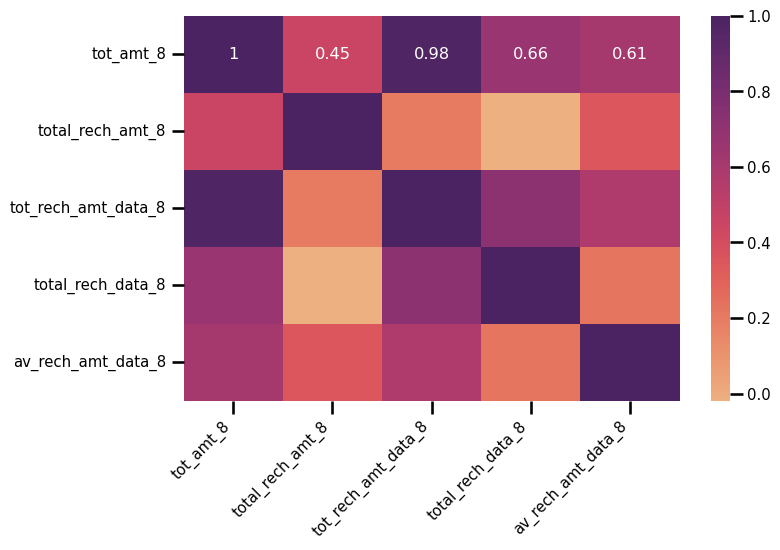

In [12]:
x = ['tot_amt_8', 'total_rech_amt_8', 'tot_rech_amt_data_8', 'total_rech_data_8', 'av_rech_amt_data_8']
plt.figure(figsize=(8,5))
fig = sns.heatmap(telecom[x].corr(), annot=True, cmap='flare')
plt.xticks(rotation=45, horizontalalignment='right')
# fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

Dropping Redundant columns, since we have already created derived features from them and derived features reflects the same information.

In [13]:
telecom.drop(['tot_rech_amt_data_6', 'tot_rech_amt_data_7','tot_rech_amt_data_8', 'tot_rech_amt_data_9'], inplace=True, axis=1)

### Identifying CHURN CUSTOMERS
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [14]:
# Where summation of columns = 0 then churn = 1 else 0
telecom['churn'] = np.where(telecom[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0,1,0)

In [15]:
# Removing all features having '_9', etc. in their names
telecom.drop(telecom.filter(regex='_9|sep', axis=1).columns, axis=1, inplace=True)

In [16]:
pd.DataFrame(round(telecom['churn'].value_counts(normalize=True)*100,2))

,proportion
churn,
0,91.86
1,8.14


Approximately 92% customers not churned and 8% customers got churned. Also, we can see class imbalance is there and we will deal with it later

For each feature, it counts the values of that feature. If the most recurrent value of the feature is repeated almost in all the instances (**zeros / len(X) * 100 > 95**). Then it drops these features because their values are almost the same for all instances and will not help in learning process and those features are not useful in our prediction.

In [17]:
telecom.shape

(30001, 176)

In [18]:
def redundant_features(df):
    redundant = []
    for i in df.columns:
        counts = df[i].value_counts()
        count_max = counts.iloc[0]
        if count_max / len(df) * 100 > 95:
            redundant.append(i)
    redundant = list(redundant)
    return redundant

In [19]:
print('Before dropping Redundant features: ', telecom.shape)
redundant_features = redundant_features(telecom)
telecom = telecom.drop(redundant_features, axis=1)
print('After dropping Redundant features: ', telecom.shape)

Before dropping Redundant features:  (30001, 176)
After dropping Redundant features:  (30001, 161)


Function to impute NaN values where %age of missing values > 40%, Reason for taking cutoff 40% is beacuse for these columns we can replace NaN with 0(for example, fb_user_7, not used facebook(NaN),av_rech_amt_data_8, not done recharge(NaN) similarly for other columns.

In [20]:
""" 
# Function to impute NaN with 0
Function to impute NaN values where %age of missing values > 40%,
Reason for taking cutoff 40% is beacuse for these columns we can replace NaN with 0
(for example, fb_user_7, not used facebook(NaN),av_rech_amt_data_8, not done recharge(NaN) similarly for other columns.
"""

def imputeNaN(df, col_name):
    for col in col_name:
        df[col].fillna(0, inplace=True)

col_40 = calnullpercentage(telecom)[calnullpercentage(telecom)['Percentage'] > 40].index

# Call Function
imputeNaN(telecom, col_40)

In [21]:
calnullpercentage(telecom)

,Total,Percentage
loc_ic_t2f_mou_8,1174,3.913203
std_ic_t2t_mou_8,1174,3.913203
std_ic_t2f_mou_8,1174,3.913203
std_og_t2t_mou_8,1174,3.913203
std_og_mou_8,1174,3.913203
loc_og_mou_8,1174,3.913203
std_ic_t2m_mou_8,1174,3.913203
loc_og_t2c_mou_8,1174,3.913203
std_ic_mou_8,1174,3.913203
isd_og_mou_8,1174,3.913203


As we can see from above missing value dataframe and value count == 0, large percentage of values are zero in missing value columns. I can impute most missing value column having NaN value with 0 if I assume that they have not use local incoming service, special outgoing service that is why these columns have NaN values. But this assumption doesn't helping much beacuse most values in these columns have 0 and it infers the same thing. So Imputing missing values for columns mentioned above.

In [22]:
pd.DataFrame((telecom[calnullpercentage(telecom).index] == 0).sum().head())

,0
loc_ic_t2f_mou_8,9189
std_ic_t2t_mou_8,13354
std_ic_t2f_mou_8,21248
std_og_t2t_mou_8,13297
std_og_mou_8,7468


In [23]:
imput_col = list(set(calnullpercentage(telecom).index) - set(('date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8')))
knn_imp = KNNImputer()
telecom[imput_col] = knn_imp.fit_transform(telecom[imput_col])
calnullpercentage(telecom)

,Total,Percentage
date_of_last_rech_8,583,1.943269
date_of_last_rech_7,98,0.326656
date_of_last_rech_6,73,0.243325


In [24]:
telecom.fillna(0, inplace=True)
# Checking % of null values
calnullpercentage(telecom)

,Total,Percentage


In [25]:
telecom.shape

(30001, 161)

In [26]:
# Checking missing value percentage if any
calnullpercentage(telecom)

,Total,Percentage


In [27]:
telecom.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tot_amt_6,tot_amt_7,avg_amt_6_7,tot_amt_8,churn
0,7000842753,197.385,214.816,213.803,0.402,0.00,0.00,2.176,2.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.402,0.00,0.00,1.098,0.106,0.00,0.00,0.07,0.00,1.078,0.566,0.00,1.50,0.176,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,1.12,2.752,0.00,0.248,0.00,0.00,0.00,2.764,1.53,0.16,2.986,6.252,4.13,1.452,0.386,1.15,7.204,8.17,5.44,0.632,0.00,0.00,6.856,2.85,0.00,0.00,0.00,0.00,7.488,2.85,0.00,0.00,0.00,5.44,0.026,0.04,0.0,0.062,0.00,0.00,0.472,0.036,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,614.0,504.0,559.0,504.0,1
7,7000701601,1069.180,1349.850,3171.480,57.840,54.68,52.29,453.430,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.390,31.38,40.28,308.630,447.380,162.28,62.13,55.14,53.23,0.000,0.000,0.00,422.16,533.910,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.000,6.50,0.000,487.53,609.24,350.16,58.140,32.26,27.31,217.560,221.490,121.19,152.160,101.460,39.53,427.880,355.23,188.04,36.890,11.83,30.39,91.440,126.99,141.33,52.19,34.24,22.21,180.540,173.08,193.94,626.46,558.04,428.74,0.210,0.00,0.0,2.060,14.53,31.59,15.740,15.190,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0

In [28]:
# No Duplicate mobile number
len(telecom['mobile_number'].unique())

30001

In [29]:

telecom.drop('mobile_number', inplace=True, axis=1)


### **Data Visualisation and EDA**

In [30]:
def showvalues(ax, m=None):
    for p in ax.patches:
        ax.annotate(
            '%.1f' % p.get_height(),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='k', rotation=0, xytext=(0,7),
            textcoords='offset points', fontweight='light', alpha=.9)

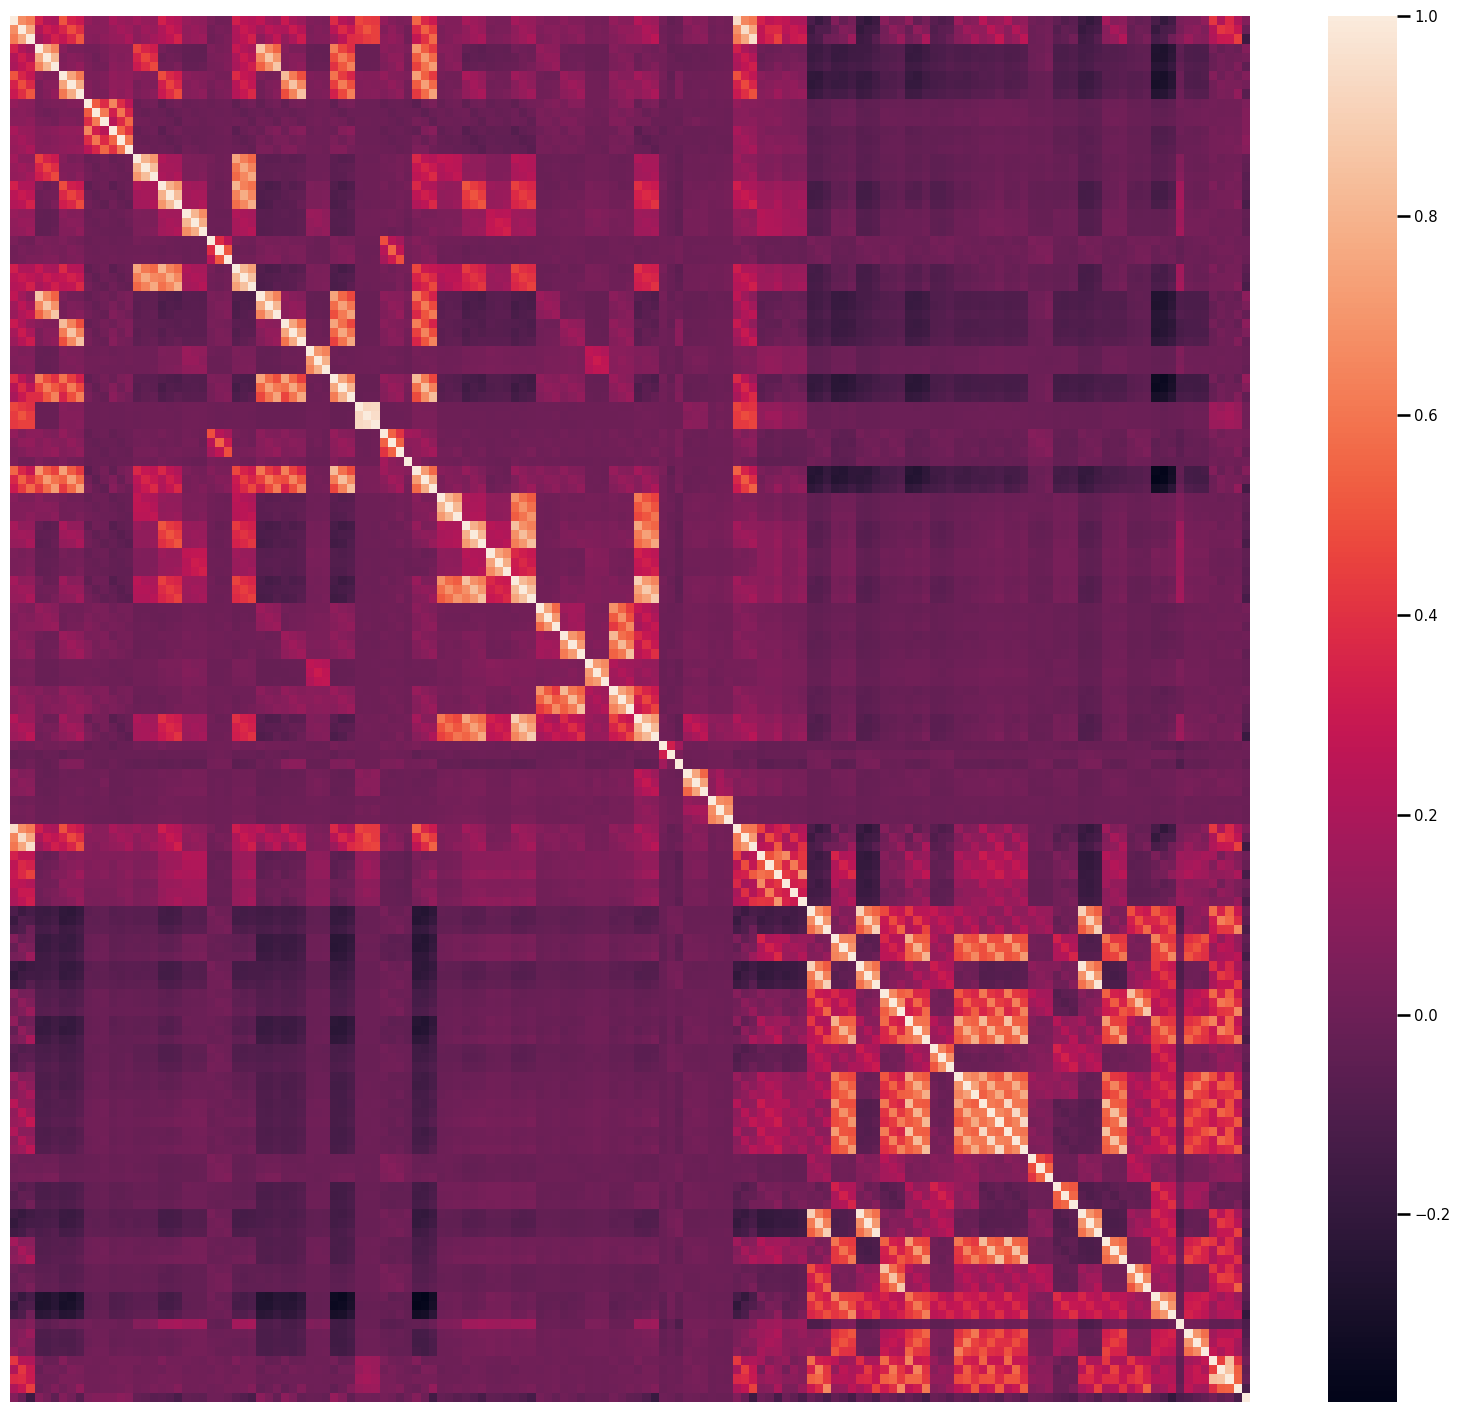

In [31]:
# Corr between numerical variables
plt.figure(figsize=(20,18))
ax = sns.heatmap(telecom.corr(numeric_only=True))
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(
    top=False, bottom=False, left=False, right=False,
    labelleft=False, labelbottom=False
)

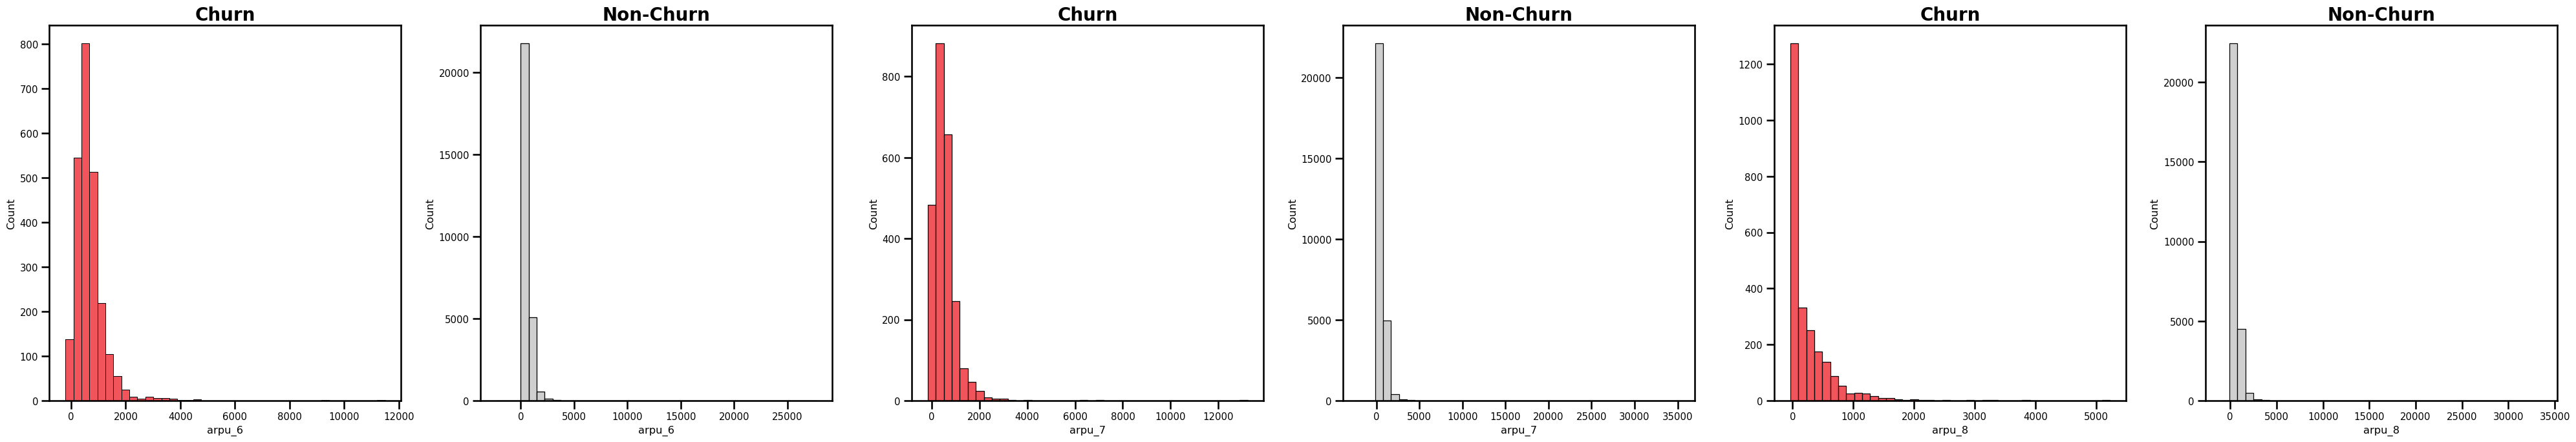

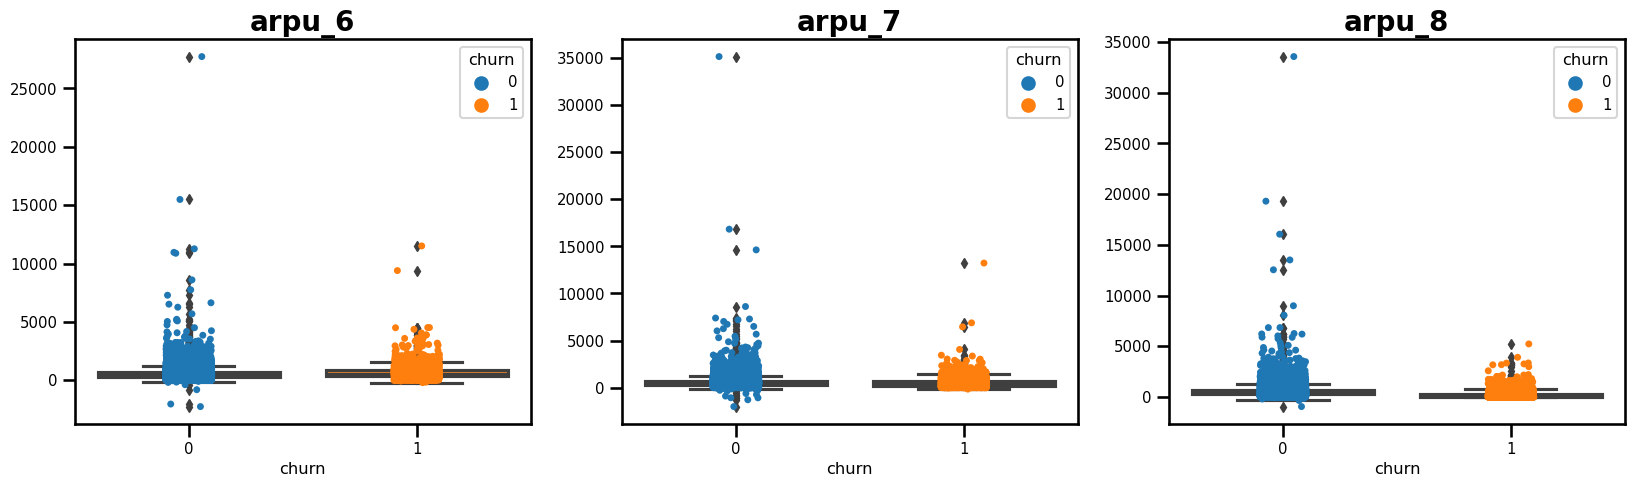

In [67]:
# Function to plot distribution plot for months (6,7 and 8) for churn and non churn customers
# Also plotting boxplot and strip plot for the same

def plot_distribution(ax, data, column, title, color):
    sns.histplot(data[column], bins=40, ax=ax, kde=False, color=color, kde_kws={'alpha': 1})
    ax.set_title(title, fontweight='bold', size=20)
    plt.tight_layout()

def plot_box_strip(ax, data, column):
    sns.boxplot(x='churn', y=column, data=data, ax=ax)
    sns.stripplot(x='churn', y=column, data=data, jitter=True, edgecolor='gray', ax=ax, hue='churn')
    ax.yaxis.label.set_visible(False)
    ax.set_title(column, fontweight='bold', size=20)

def dist_box_plot(df, col1, col2, col3):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(40, 7))
    
    plot_distribution(axes[0], df[df['churn'] == 1], col1, 'Churn', '#ED1C24')
    plot_distribution(axes[1], df[df['churn'] == 0], col1, 'Non-Churn', '#C0C0C0')
    plot_distribution(axes[2], df[df['churn'] == 1], col2, 'Churn', '#ED1C24')
    plot_distribution(axes[3], df[df['churn'] == 0], col2, 'Non-Churn', '#C0C0C0')
    plot_distribution(axes[4], df[df['churn'] == 1], col3, 'Churn', '#ED1C24')
    plot_distribution(axes[5], df[df['churn'] == 0], col3, 'Non-Churn', '#C0C0C0')
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    plot_box_strip(axes[0], df, col1)
    plot_box_strip(axes[1], df, col2)
    plot_box_strip(axes[2], df, col3)    
    
    plt.show()

# Contoh pemanggilan fungsi
dist_box_plot(telecom, 'arpu_6', 'arpu_7', 'arpu_8')

1. Consistent Pattern Across Months:

* The pattern of ARPU for churned and non-churned customers is consistent across the three months (June, July, August). In each month, non-churned customers generally have higher ARPU values compared to churned customers.

2. Distribution of ARPU:

* For non-churned customers, ARPU distribution shows a higher concentration of values towards the lower end, but there are significantly higher outliers, indicating that some non-churned customers generate very high revenue.
For churned customers, ARPU is concentrated even more towards the lower end with fewer high outliers, suggesting that customers with lower revenue contributions are more likely to churn.

3. Churned vs. Non-Churned ARPU:

* There is a noticeable difference in the median ARPU between churned and non-churned customers. Non-churned customers have a higher median ARPU, indicating that customers generating more revenue are less likely to churn.

4. Insights from Distribution Plots:

* The distribution plots show that the majority of churned customers have ARPU values clustered around lower amounts, whereas non-churned customers, while still having a concentration at lower ARPU values, include a significant number with higher ARPU values.

As we can see average revenue per user is decreasing for churn customers in 8th month.Also there are lots of outlier exists in revenue as some customers might using higher data and recharging frequently.

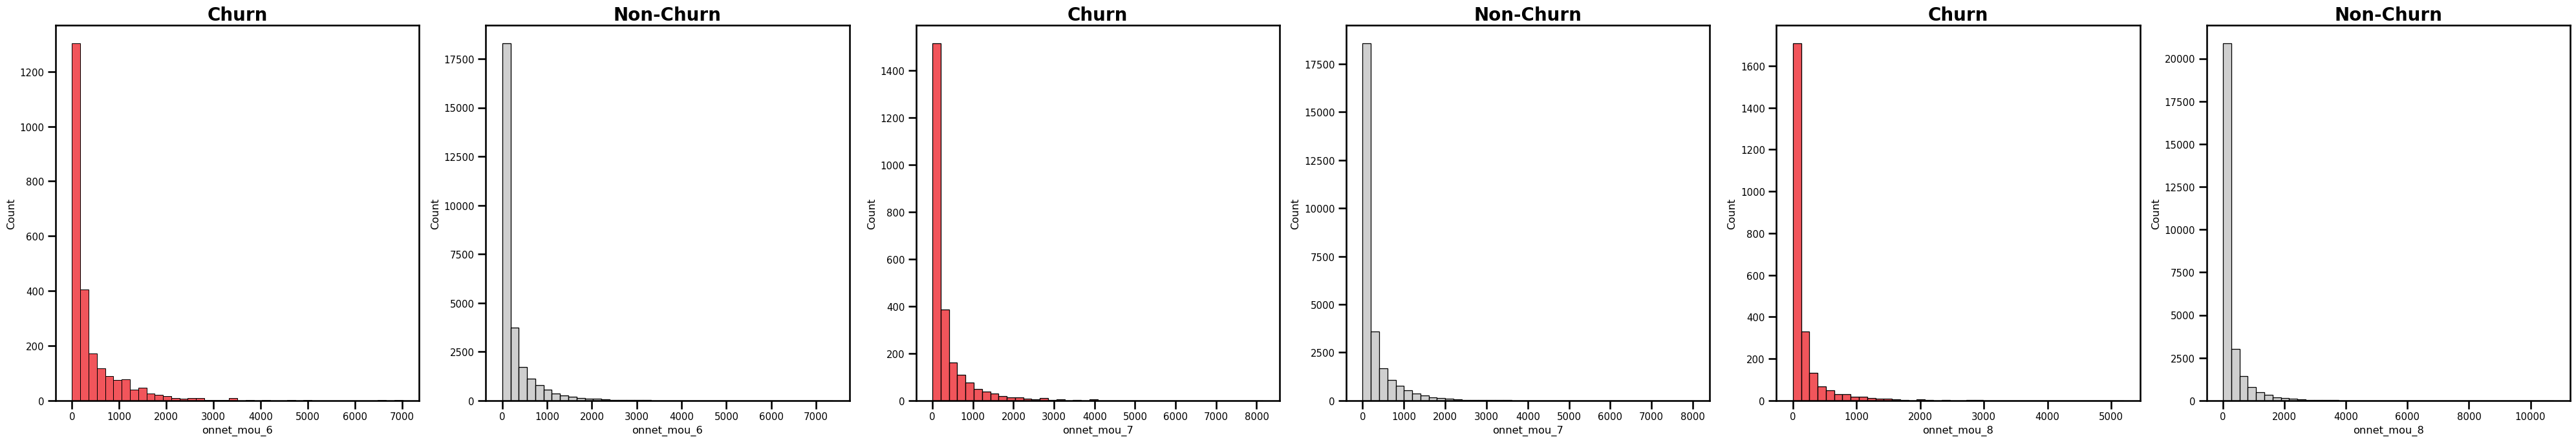

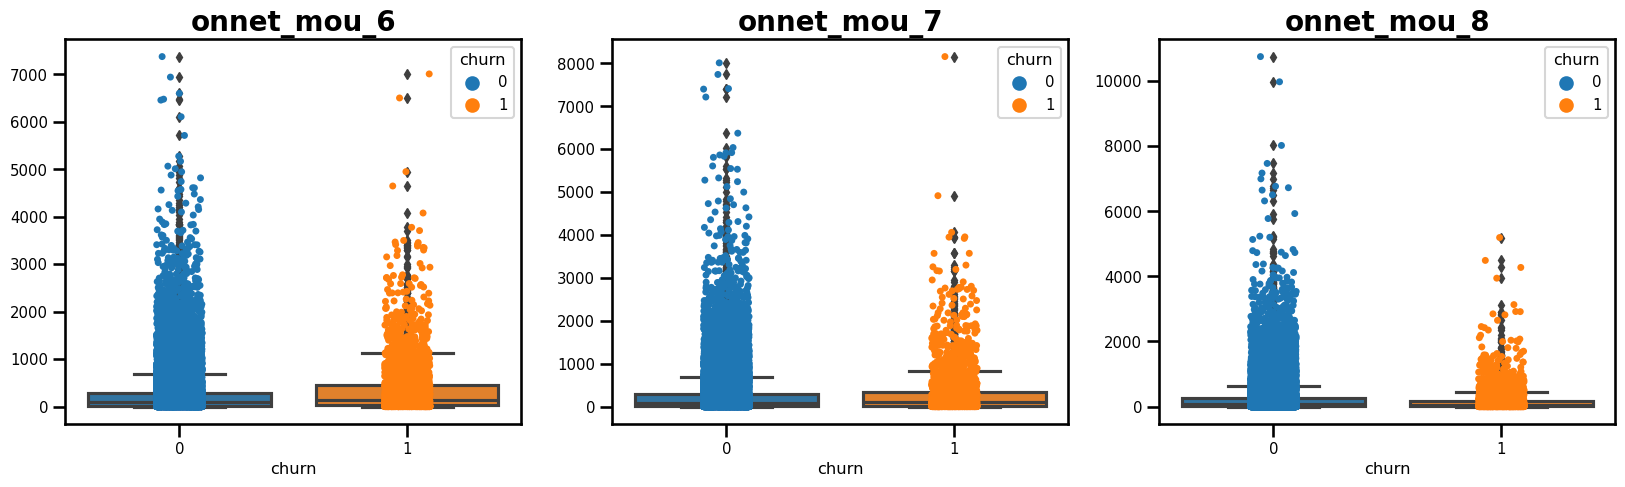

In [68]:
# onnet_mou (Minutes of Usage for all kind of calls within the same operator network)
dist_box_plot(telecom, 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8')

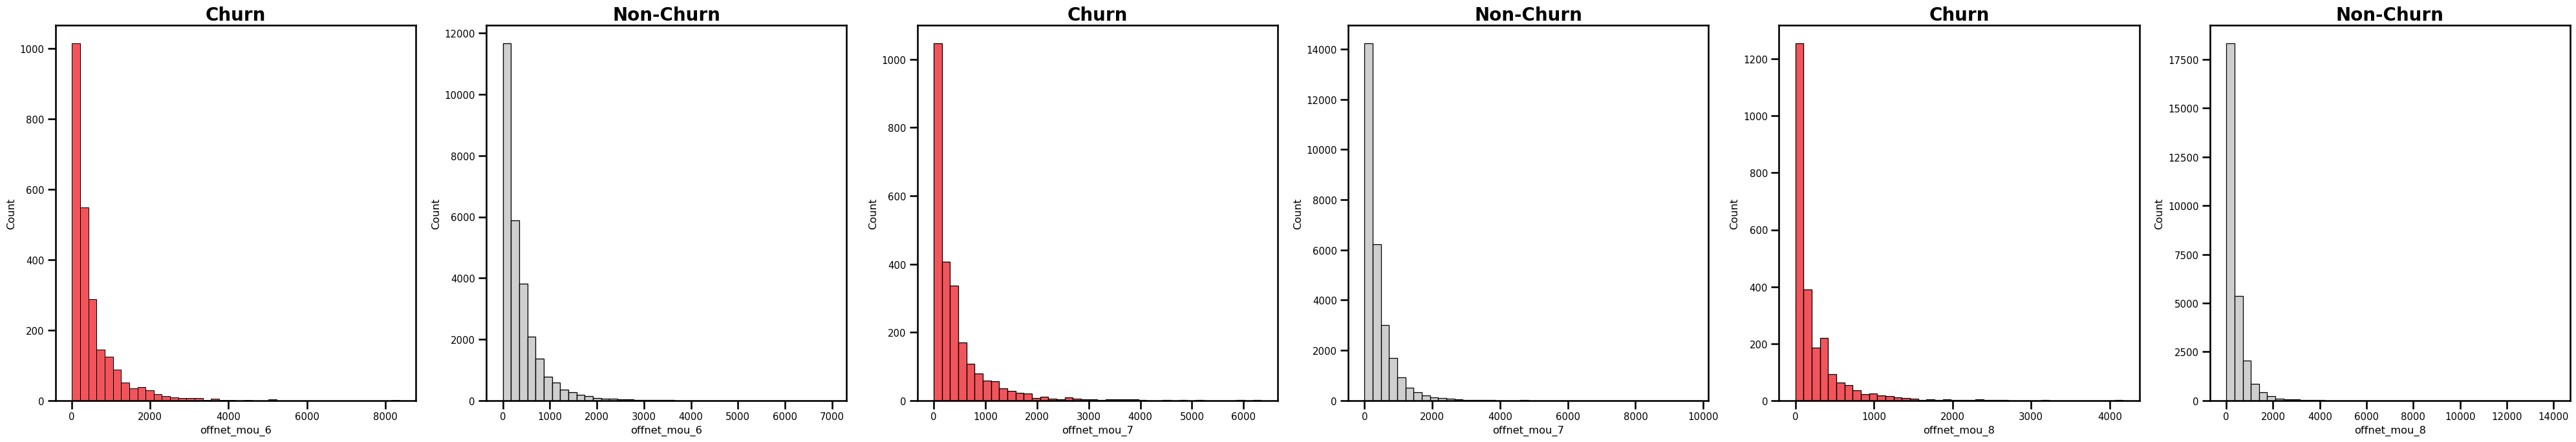

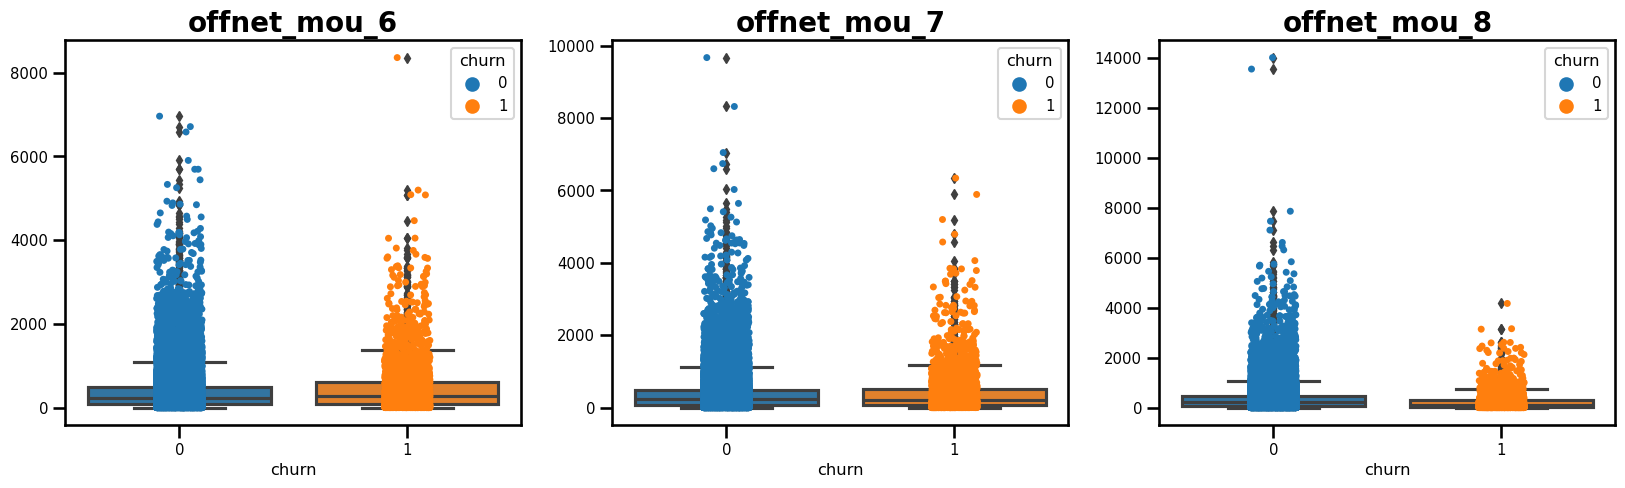

In [69]:
# offnet_mou (Minutes of Usage for all kind of calls outside the operator T network)
dist_box_plot(telecom, 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8')

Similalry Offnet minutes of usage is also decreasing for churn customers in 8th month.As compared to 6th and 7th month , in 8th month there is no high minutes of usage as the gitter graph is condensed.

In [35]:
# import pygwalker as pyg
# walker = pyg.walk(telecom, theme_key='vega', dark='light', kernel_computation=True, kanaries_api_key='ak-8ac65ba5e922aa75e5ce395e5042ed3f420d1c8bc6c193882a5c2a24e17105f3')